In [249]:
from __future__ import print_function
import os
import shutil
import sys
import PIL
import glob
from matplotlib.pyplot import imshow
from PIL import  Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import cPickle
import itertools
%matplotlib notebook


In [250]:
#step 1 : read in bundle file
#step 2 : get the "0-cam" rate
#step 3 : if rate < thresh(or other heuristic):  we claim it is not good enough
#step 4 : first compute all the world-coordinate position for all valid segments (also for invalid bundle)
#step 5 : We can save them in a matrix-like
#step 6 : Store in file

In [310]:
def parseBundlerFile(fname):
    f = open(fname,'r')
    count = 0

    for lines in f.readlines():
        count = count + 1
        if count == 1: 
            # this is the title file
            continue
        elif count == 2:
            # second line is num cameras & num keypoints
            tmp = lines.split()
            num_cam = int(tmp[0])
            num_point = int(tmp[1])
            # the reading limit for camera information, each cam is described by 5 lines
            cam_limit = count + 5 * num_cam
            w, h = 3, 5*num_cam
            # camera information output
            CAM = [[0 for x in range(w)] for y in range(h)] 
            w_p,h_p = 3,3*num_point
            p_flag = 0
            PNT = [[0 for x in range(w_p)] for y in range(h_p)]
        elif count <= cam_limit:
            # those 0,1,2 has different meaning for different lines but all lines has 3 numbers
            CAM[count-3][0] = float(lines.split()[0])
            CAM[count-3][1] = float(lines.split()[1])
            CAM[count-3][2] = float(lines.split()[2])
        else:
            p_flag = p_flag + 1
            if p_flag == 1:
                #print count,h
                # 3D position
                for pos in range(0,3):
                    PNT[count-h-3][pos] = float(lines.split()[pos])
            elif p_flag == 2:
                #print count,h
                # RGB color of this keypoint
                for rgb_p in range(0,3):
                    PNT[count-h-3][rgb_p] = float(lines.split()[rgb_p])
            elif p_flag == 3:
                p_flag = 0
                sp=lines.split()
                assert(len(sp)==(4*int(sp[0])+1))
                for view_p in range(4*int(sp[0])):
                    sp[view_p+1]=float(sp[view_p+1])
                PNT[count-h-3]=sp[1:]
    f.close()
    return CAM, PNT

def parseCam(cam):
    # parse the camera into better format
    cam=np.asarray(cam)
    out=[]
    num_cam=int(len(cam)/5)
    for i in range(num_cam):
        this_cam={}
        subcam=cam[i*5:(i+1)*5]
        this_cam["focal_len"]=subcam[0][0]
        this_cam["distort_coeff"]=subcam[0][1:]
        this_cam["R"]=np.matrix(subcam[1:4])
        this_cam["t"]=np.matrix(subcam[4]).T
        out.append(this_cam)
    return out

def parseKeypoints(pnt):
    num_keypoint=int(len(pnt)/3)
    out=[]
    for i in range(num_keypoint):
        this_point={}
        subpnt=pnt[i*3:(i+1)*3]
        this_point["position"]=np.matrix(subpnt[0]).T
        this_point["color"]=np.asarray(subpnt[1])
        # parse the occur of this keypoint in all cameras
        view_list=[]
        for j in range(int(len(subpnt[2])/4)):
            this_cam={}
            subsubpnt=subpnt[2][j*4:(j+1)*4]
            this_cam["camera_index"]=int(subsubpnt[0])
            this_cam["sift_index"]=int(subsubpnt[1])
            this_cam["position"]=np.matrix(subsubpnt[2:]).T
            view_list.append(this_cam)
        this_point["view_list"]=view_list
        
        out.append(this_point)
    return out
def getdata(filename):
    cam, kp = parseBundlerFile(filename)
    cam = parseCam(cam)
    kp = parseKeypoints(kp)
    point_num = len(kp)
    total_num = len(cam)
    zero_num = 0
    pos_matrix = [[0 for x in range(total_num)] for y in range(total_num)] 
    tensor_pos = []
    return cam, kp, point_num, total_num, zero_num, pos_matrix, tensor_pos
def position(cam_1,cam_2):
    cam_2_world = -cam_2['R'].T*cam_2['t']
    position = cam_1['R']*cam_2_world + cam_1['t']
    position = position.T
    position = position.tolist()[0]
    return position

def cam_worlds(cams):
    out=np.zeros(shape=(3, len(cams)))
    for i, cam in enumerate(cams):
        cam_world = -cam['R'].T*cam['t']
        out[:, i]=np.squeeze(cam_world)
        
    return out

def position_vec(cam1, cam_world_locs):
    pos = cam1['R']*cam_world_locs + cam1['t'] # output shape = 3*n
    pos = pos.T
    pos = pos.ravel()
    pos = pos.tolist()[0]
    return pos
    
def data_update(total_num, cam, zero_num, filename,pos_matrix, tensor_pos):
    dist = [0]
    cam_world_locs = cam_worlds(cam)
    history = []
    for i in xrange(0,total_num):
        if  np.count_nonzero(cam[i]['R'])==0  and np.count_nonzero( cam[i]['t'] ) == 0:
            zero_num = zero_num + 1
        if i !=total_num-1:
            dist.append(np.linalg.norm(cam[i+1]['t']-cam[i]['t']))    
        this_pos=position_vec(cam[i], cam_world_locs)
        history = itertools.chain(history,[0]*(total_num-1-i)*3,this_pos[0:(i+1)*3])
        tensor_pos = itertools.chain(tensor_pos, this_pos)
    tmp = filename.split('/')
    name = tmp[1]+'/'+tmp[2]
    return dist, pos_matrix, name, zero_num, tensor_pos, history
def get_stop(total_num, cam, zero_num, filename,pos_matrix, dist, avg):
    stop = [-1,-1]
    epsilon = 0.8*avg#0.009
    for i in xrange(2,total_num):
        if dist[i] < epsilon and dist[i-1] < epsilon and dist[i]<0.02:
            stop.append(1)
        else:
            stop.append(0)
    return stop
    #stop = [1,1]
    

In [367]:
def process_all(data):
    # read file in a loop
    file_num = 0;
    '''namelist = ['001/seg11',
                '003/seg07',
                '012/seg05',
                '014/seg02',
                '018/seg03',
                '020/seg05',
                '021/seg07',
                '027/seg01',
                '027/seg02',
                '059/seg04',
                ]'''
    
    #namelist = []
    all_file = sorted(glob.glob(os.path.join('./', '*','seg*','bundle', 'bundle.out')))
    for ifile, filename in enumerate(all_file):
        cam,kp,point_num, total_num,zero_num, pos_matrix, tensor_pos = getdata(filename)
        file_num = file_num + 1;

        # check camera
        dist, pos_matrix, name, zero_num, tensor_pos, history= \
            data_update(total_num, cam, zero_num, filename,pos_matrix, tensor_pos)
        #if not name in namelist:
        #    continue
        avg  = sum(dist)/len(dist)
        tense_flag = [ x<3*avg for x in dist]
        dist_used_for_speed = [x*int(y) for x,y in zip(dist,tense_flag)]
        tense_avg = sum(dist_used_for_speed)/len(dist_used_for_speed)
        flag = [x<5*avg for x in dist]
        index = [i for i, j in enumerate(flag) if j == True]
        stop = get_stop(total_num, cam, zero_num, filename,pos_matrix, dist, tense_avg)
        for iflag, content in enumerate(flag): 
            if content == False:
                stop[iflag] = -1
        this_data = {"video_name":name,
                     "cam_num":total_num,
                     "egomotion":list(tensor_pos),
                     "can_use":0,
                     "valid_label":flag,
                     "stop_label":stop,
                     "ego_history":list(history),
                     "dist":dist
                    }

        rate = float(zero_num)/float(total_num)
        if rate <=0.05 and point_num > 1500 and len(dist)==150:
            # ok the data seems good here! this is tight! We can relax this later.
            this_data["can_use"] = 1
        data.append(this_data)
        print(file_num,name,this_data['can_use'])
        print(float(stop.count(1))/float(len(stop)))
        #print(len(list(history)))
        #break
        print(tense_avg)
        #print(stop)
        #print(dist)
        #plt.figure()
        #plt.plot(dist/avg)
        #print()

In [368]:
data=[]
process_all(data)

1 001/seg01 1
0.00666666666667
0.0744793354019
2 001/seg02 0
0.226666666667
0.269837286371
3 001/seg03 1
0.0
0.203859785722
4 001/seg04 0
0.0666666666667
1.97418072275
5 001/seg05 1
0.00666666666667
0.134515125271
6 001/seg06 0
0.493333333333
0.122213426272
7 001/seg07 1
0.00666666666667
0.0331884116174
8 001/seg08 1
0.0666666666667
0.0530331892375
9 001/seg09 1
0.126666666667
0.0138859911933
10 001/seg10 1
0.16
0.0163043838204
11 001/seg11 0
0.4
0.0118174590413
12 001/seg12 0
0.226666666667
0.0118006086245
13 001/seg13 0
0.0133333333333
0.212613783938
14 001/seg14 0
0.106666666667
0.0742358681469
15 001/seg15 0
0.32
0.0185434834966
16 001/seg16 0
0.2
0.126363184458
17 002/seg01 0
0.0866666666667
1.13702906134
18 002/seg02 0
0.0466666666667
9.17697802759
19 002/seg03 0
0.146666666667
0.264357481211
20 002/seg04 0
0.56
0.063314887932
21 002/seg05 0
0.146666666667
0.309323113137
22 002/seg06 1
0.146666666667
0.346975087187
23 002/seg07 1
0.4
0.0203133317097
24 002/seg08 0
0.625
0.0068930

11 001/seg11 0
0.4
0.0118174590413
[-1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>


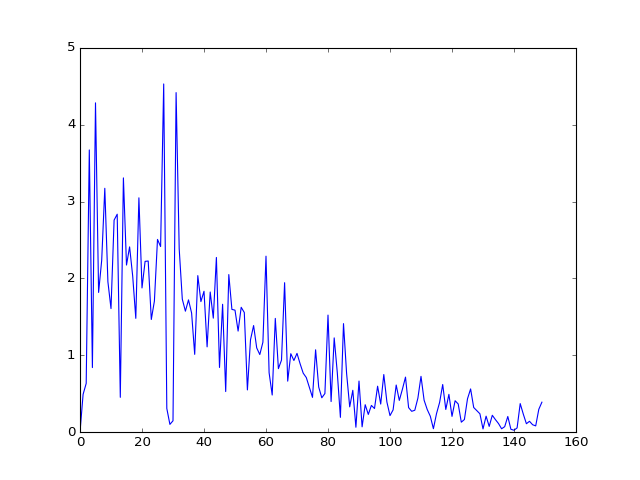

31 003/seg07 1
0.0
0.0650406667602
[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


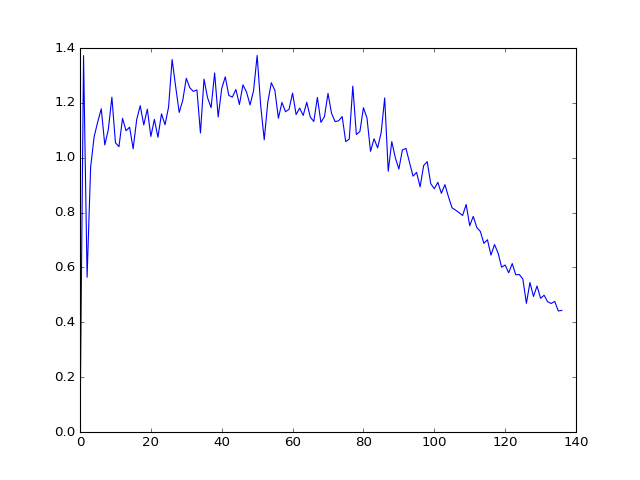

93 012/seg05 1
0.153333333333
0.0772648966244
[-1, -1, 0, 0, -1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


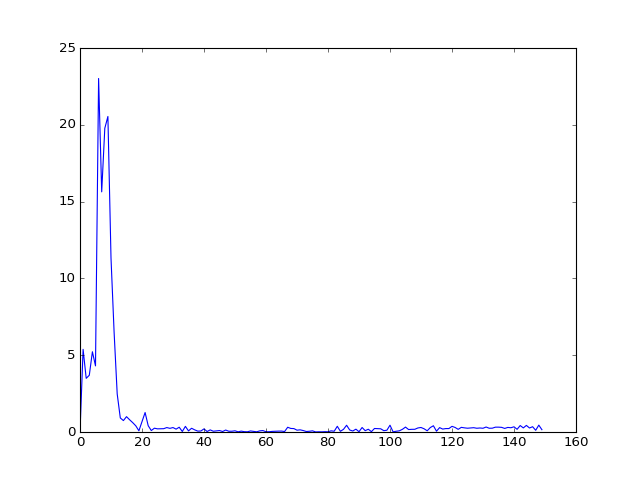

106 014/seg02 0
0.4
0.0218120817788
[-1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


<IPython.core.display.Javascript object>


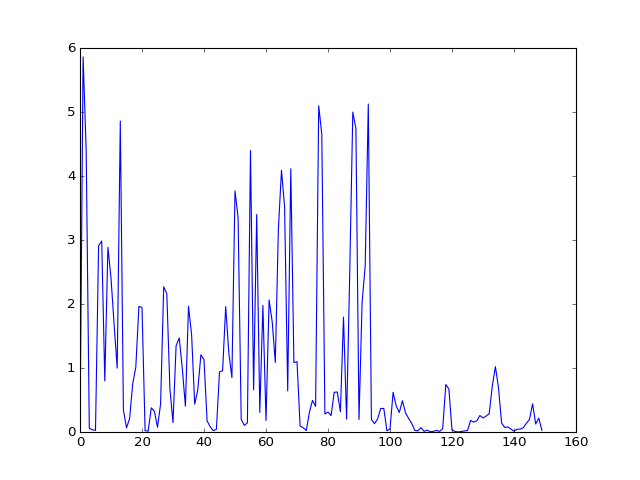

134 018/seg03 0
0.286666666667
0.205389395894
[-1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 1, 1, 0, -1, -1, 0, 0, 0, 1]


<IPython.core.display.Javascript object>


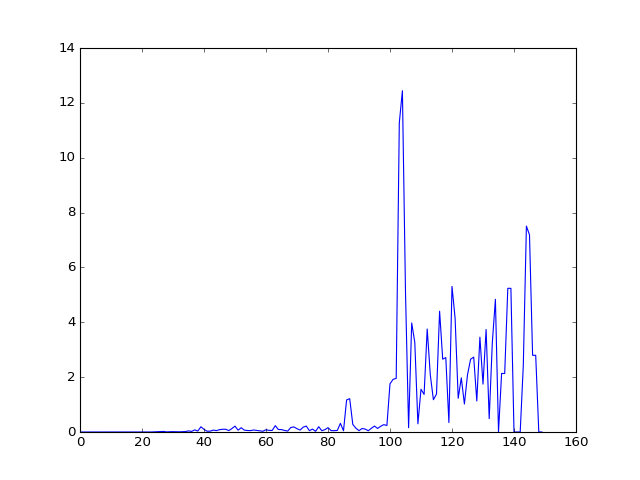

152 020/seg05 1
0.133333333333
0.192141988754
[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]


<IPython.core.display.Javascript object>


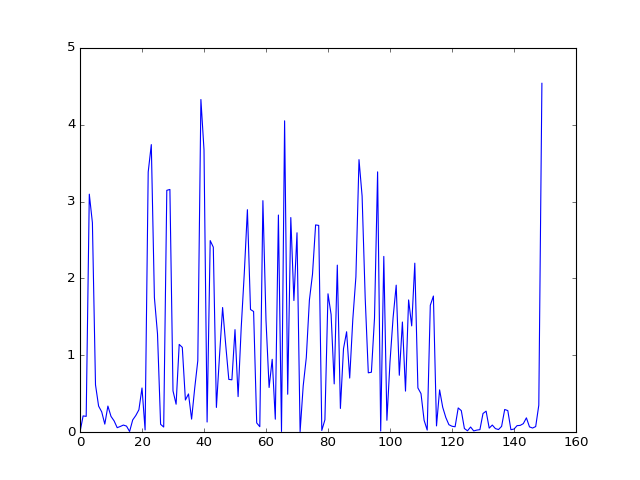

162 021/seg07 1
0.449275362319
0.00823215030227
[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>


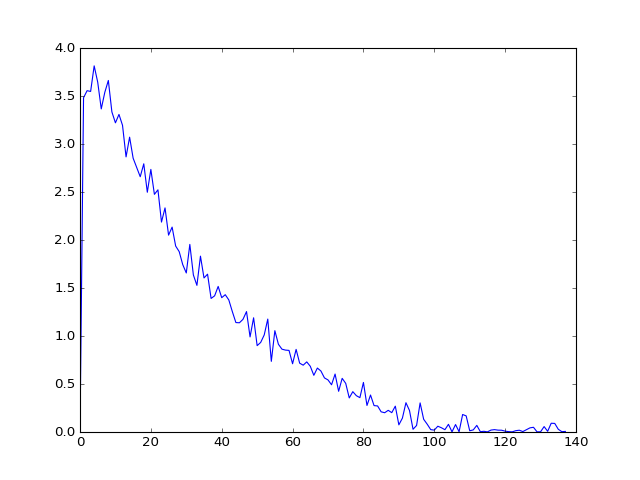

201 027/seg01 0
0.313333333333
0.0274410550556
[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


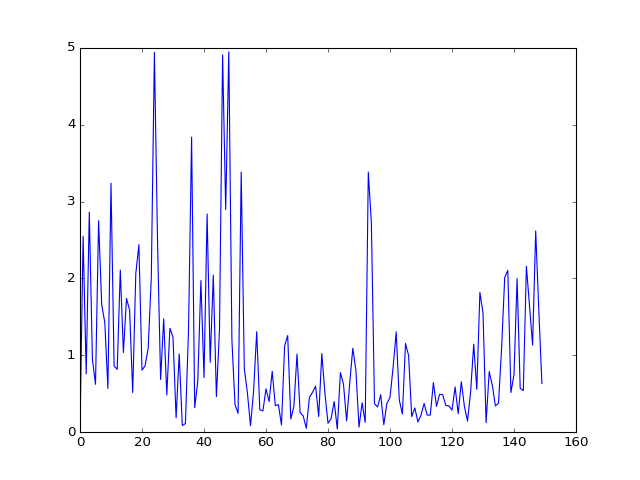

202 027/seg02 1
0.193333333333
0.0653624392243
[-1, -1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, 0, 0]


<IPython.core.display.Javascript object>


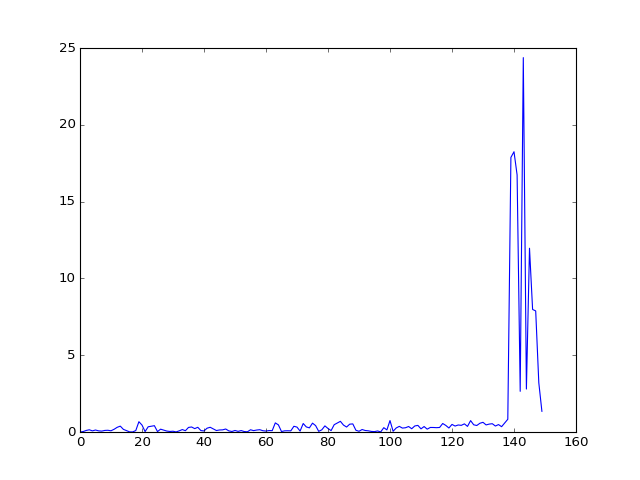

428 059/seg04 1
0.513333333333
0.0165094118159
[-1, -1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, -1, -1, 0, -1, 0, 0, -1, 0, 0, 0, -1, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>


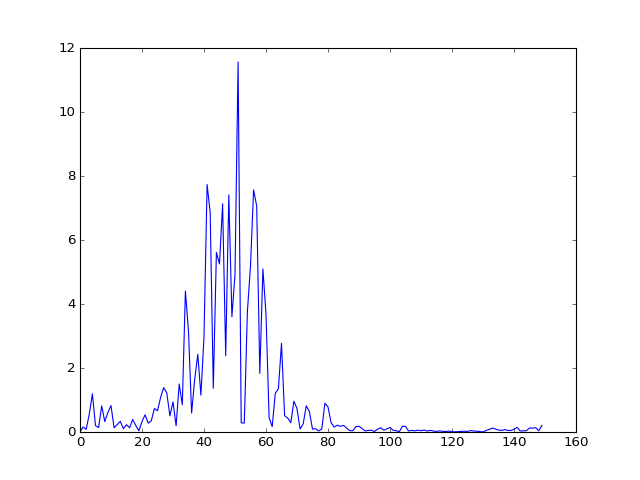

In [331]:
import cProfile
#cProfile.run('process_all()')
luck = []
process_all(luck)
#001/seg11  stop at last
#012/seg05  not actually stopped, but from 1/3 to 1/2 it's very very slow
#014/seg02  stopped for the whole time
#018/seg03  stopped at first 1/4 and go until the last a few frames
#020/seg05  very slow at first, then accelerate, not acctually stopped
#021/seg07  stopped at last 1/4
#027/seg01  stopped from 2/3 to last
#027/seg02  stopped from start to 1/2
#059/seg04  stopped at half


In [88]:
cPickle.dump(data, open("data.dat", "w"))

obj = cPickle.load(open("data.dat", "r"))
print(len(obj))
not_valid = 0
for i in range(0,len(data)):
    if data[i]["valid"] == 0:
        not_valid = not_valid + 1
print(not_valid)
print(len(data))

859


In [369]:
valid_data = [d for i, d in enumerate(data) if d['can_use'] == 1]
len(valid_data)

220

In [370]:
cPickle.dump(valid_data, open("valid_data.dat", "w"))

In [332]:
class KalmanFilter(object):

    def __init__(self, process_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def input_latest_noisy_measurement(self, measurement):
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate


<IPython.core.display.Javascript object>


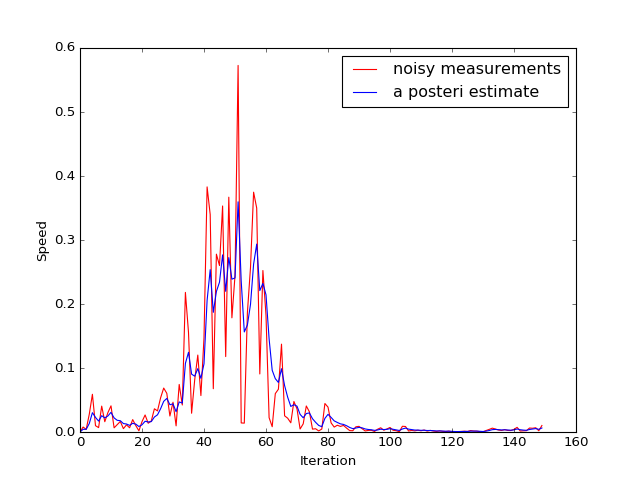

In [364]:
    import random
    import pylab
    iteration_count = 150

    #actual_values = [-0.37727 + j * j * 0.00001 for j in xrange(iteration_count)]
    noisy_measurement = data[9]['dist']

    # in practice we would take our sensor, log some readings and get the
    # standard deviation
    measurement_standard_deviation = 0.05

    # The smaller this number, the fewer fluctuations, but can also venture off
    # course...
    process_variance = 5e-4
    estimated_measurement_variance = measurement_standard_deviation ** 2  # 0.05 ** 2
    kalman_filter = KalmanFilter(process_variance, estimated_measurement_variance)
    posteri_estimate_graph = []

    for iteration in xrange(0, iteration_count):
        kalman_filter.input_latest_noisy_measurement(noisy_measurement[iteration])
        posteri_estimate_graph.append(kalman_filter.get_latest_estimated_measurement())

    import pylab
    pylab.figure()
    pylab.plot(noisy_measurement, color='r', label='noisy measurements')
    pylab.plot(posteri_estimate_graph, 'b-', label='a posteri estimate')
    #pylab.plot(actual_values, color='g', label='truth value')
    pylab.legend()
    pylab.xlabel('Iteration')
    pylab.ylabel('Speed')
    pylab.show()

In [390]:
for i in xrange(0,len(valid_data)):
    print('workingDir{'+str(i+1)+'} = [\'../../../Downloads/labeling/\',','\''+valid_data[i]['video_name']+'/viz/'+'\'','];' )
    #print('mkdir','./'+valid_data[i]['video_name'])
    #print(
    #    'scp -r hxu@durian9.banatao.berkeley.edu:/home/hxu/Reconstruction/bundler_sfm/data/videos/'
    #    +valid_data[i]['video_name']
    #    +'/viz/',
    #    './'+valid_data[i]['video_name'])


workingDir{1} = ['../../../Downloads/labeling/', '001/seg01/viz/' ];
workingDir{2} = ['../../../Downloads/labeling/', '001/seg03/viz/' ];
workingDir{3} = ['../../../Downloads/labeling/', '001/seg05/viz/' ];
workingDir{4} = ['../../../Downloads/labeling/', '001/seg07/viz/' ];
workingDir{5} = ['../../../Downloads/labeling/', '001/seg08/viz/' ];
workingDir{6} = ['../../../Downloads/labeling/', '001/seg09/viz/' ];
workingDir{7} = ['../../../Downloads/labeling/', '001/seg10/viz/' ];
workingDir{8} = ['../../../Downloads/labeling/', '002/seg06/viz/' ];
workingDir{9} = ['../../../Downloads/labeling/', '002/seg07/viz/' ];
workingDir{10} = ['../../../Downloads/labeling/', '003/seg01/viz/' ];
workingDir{11} = ['../../../Downloads/labeling/', '003/seg02/viz/' ];
workingDir{12} = ['../../../Downloads/labeling/', '007/seg05/viz/' ];
workingDir{13} = ['../../../Downloads/labeling/', '007/seg06/viz/' ];
workingDir{14} = ['../../../Downloads/labeling/', '007/seg07/viz/' ];
workingDir{15} = ['../../../D